In [1]:
import torch
import torch.nn.functional as F
import math


class Layer(torch.nn.Module):
    def __init__(
        self,
        in_features = 2,
        out_features = 5,
        grid_range = [-1,1],
        grid_size = 5, # Number of knot/control point in the interval -1 , 1
        spline_order = 3, # polynomial of order 2
        sigma = 0.1, # sigma in footnote 2 of page 6

        base_activation = torch.nn.SiLU(),
    ):
        super(Layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        grid_spacing = (grid_range[1] - grid_range[0]) / grid_size
        grid = ((torch.arange(-spline_order, grid_size + spline_order + 1) * grid_spacing + grid_range[0] ).expand(in_features, -1))
        
        self.grid = grid
                
        self.w_b = torch.nn.Parameter(torch.Tensor(out_features, in_features)) #w_b in 2.10 in the paper

        torch.nn.init.kaiming_uniform_(self.w_b, a=math.sqrt(5)) # Xavier
        self.c_i = torch.nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order)) #C_is in 2.12 in the paper
        

        self.sigma = sigma
        self.base_activation = base_activation()
        
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.w_b, a=math.sqrt(5))
        
        noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 1 / 2) * self.sigma/ self.grid_size)
        
        self.c_i.data.copy_(self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise,))


    def b_splines(self, x):


        grid = self.grid
        x = x.unsqueeze(-1)

        # Initialize the bases tensor with zeros
        bases = torch.zeros((x.size(0), grid.size(0), grid.size(1) - 1), dtype=x.dtype, device=x.device)

        # Calculate bases for k=0
        for n in range(x.size(0)):
            for i in range(grid.size(0)):
                for j in range(grid.size(1) - 1):
                    if x[n, 0] >= grid[i, j] and x[n, 0] < grid[i, j + 1]:
                        bases[n, i, j] = 1.0
        # Iterate over the spline order
        for k in range(1, self.spline_order + 1):
            new_bases = torch.zeros((x.size(0), grid.size(0), grid.size(1) - k - 1), dtype=x.dtype, device=x.device)

            for n in range(x.size(0)):
                for i in range(grid.size(0)):
                    for j in range(grid.size(1) - k - 1):
                        left_term = 0.0
                        right_term = 0.0

                        if grid[i, j] != grid[i, j + k]:
                            left_term = ((x[n, 0] - grid[i, j]) / (grid[i, j + k] - grid[i, j])) * bases[n, i, j]

                        if grid[i, j + k + 1] != grid[i, j + 1]:
                            right_term = ((grid[i, j + k + 1] - x[n, 0]) / (grid[i, j + k + 1] - grid[i, j + 1])) * bases[n, i, j + 1]

                        new_bases[n, i, j] = left_term + right_term

            bases = new_bases
        # print(bases)
        
            
        # bases are now the basis function for the splines
        # bases[0] represent the contribution of each spline basis to the point newx[0] 
        # It follows the restriction that the sum of basis function is 1 at each point

        # assert torch.all(torch.isclose(torch.sum(bases, dim = 2), torch.ones_like(x)))
        # Now we have the basis function that makes up the spline
        
        return bases
    


    def curve2coeff(self, x, y):
        # Compute the B-spline bases for the input tensor x
        spline_bases = self.b_splines(x)  # (batch_size, in_features, grid_size + spline_order)
        spline_bases_t = spline_bases.transpose(0, 1)  # (in_features, batch_size, grid_size + spline_order)

        # Transpose the target tensor y
        y_t = y.transpose(0, 1)  # (in_features, batch_size, out_features)

        # Solve the least squares problem to find the spline coefficients
        coefficients = torch.linalg.lstsq(spline_bases_t, y_t).solution  # (in_features, grid_size + spline_order, out_features)

        # Permute the dimensions to get the correct shape
        coeffs_permuted = coefficients.permute(2, 0, 1)  # (out_features, in_features, grid_size + spline_order)

        return coeffs_permuted



    def forward(self, x):
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.w_b)
        spline_output = F.linear(
            self.b_splines(x).reshape(x.size(0), -1),
            self.c_i.reshape(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.reshape(*original_shape[:-1], self.out_features)
        return output


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        sigma=0.1,
        base_activation=torch.nn.SiLU,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                Layer(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    sigma=sigma,
                    base_activation=base_activation,
                    grid_range=grid_range,))

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        return x


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("iris.csv")

df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [4]:
from sklearn.preprocessing import LabelEncoder

LabelEncoder_y = LabelEncoder()
df['variety'] = LabelEncoder_y.fit_transform(df['variety'])

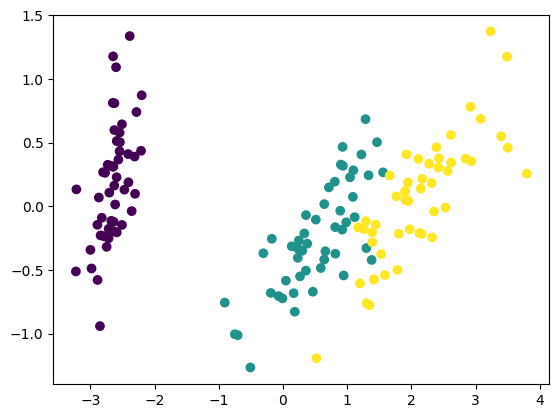

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# make dataset 2D and plot it

pca = PCA(n_components=2)

X = df.drop("variety", axis=1)
y = df["variety"]

X = pca.fit_transform(X)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()


In [6]:
X = df.iloc[:, 0:4].values
y = df.iloc[:, 4].values


X, y

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
        [5

In [7]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [8]:
import torch.optim as optim

model = KAN([4, 3, 1])

optimizer = optim.Adam(model.parameters(), lr = 0.01)
criterion = torch.nn.MSELoss()

In [9]:
n_epochs = 20

for epoch in range(n_epochs):
    optimizer.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch} Loss: {loss.item()}")

/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 1.250259518623352
Epoch 1 Loss: 0.9595373272895813
Epoch 2 Loss: 0.7835935950279236
Epoch 3 Loss: 0.7100650072097778
Epoch 4 Loss: 0.7158111929893494
Epoch 5 Loss: 0.7600979804992676
Epoch 6 Loss: 0.8008065223693848
Epoch 7 Loss: 0.8183305263519287
Epoch 8 Loss: 0.8122203946113586
Epoch 9 Loss: 0.7897400856018066
Epoch 10 Loss: 0.7602871656417847
Epoch 11 Loss: 0.7324976325035095
Epoch 12 Loss: 0.7121672630310059
Epoch 13 Loss: 0.7013890743255615
Epoch 14 Loss: 0.6992337703704834
Epoch 15 Loss: 0.7030994296073914
Epoch 16 Loss: 0.7098110914230347
Epoch 17 Loss: 0.7163723707199097
Epoch 18 Loss: 0.7205312252044678
Epoch 19 Loss: 0.7211354374885559
